<a href="https://colab.research.google.com/github/Jiet97/codeql-uboot/blob/master/F0384_%E7%AC%AC%E4%B8%89%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 程式 3.1

In [135]:
# 下載 Gridworld.py 及 GridBoard.py (-q 是設為安靜模式)
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

## 程式 3.2

In [136]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

L1 = 64 #{4} 各層的寬度
L2 = 150
L3 = 100
L4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3  #超參數『α 』
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #model.parameters()會傳回所有要優化的權重參數

gamma = 0.9
epsilon = 1.0

###將動作的字母與數字對應起來

In [137]:
action_set = {
	0: 'u',
	1: 'd',
	2: 'l',
	3: 'r'
}

## 程式 3.3(static mode)

Text(0, 0.5, 'Loss')

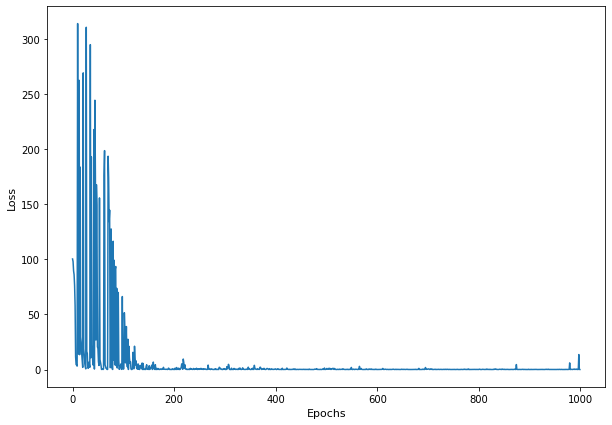

In [138]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
    game = Gridworld(size=4, mode='static')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
	#將3維陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。編註：加上雜訊的原因會在稍後說明
    state1 = torch.from_numpy(state_).float()
#將numpy陣列轉換成PyTorch張量，並存於PyTorch變數（state1）中	
    status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
    while(status == 1):
        qval = model(state1) #執行Q網路，取得所有動作的預測Q值
        qval_ = qval.data.numpy() #將qval轉換成numpy陣列
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)        
        action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
        game.makeMove(action) #執行之前ε—貪婪策略所選出的動作 
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
        reward = game.reward()
        with torch.no_grad(): #此函式的作用會在稍後說明
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
        if reward == -1:
            Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach() #此函式的作用會在稍後說明
        X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape [1, 4] 會變成 [4])
        loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
        if i%100 == 0:
          print(i, loss.item())
          clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        state1 = state2
        if abs(reward) == 10:      
	   	      status = 0 # 若 reward 不等於 –1，代表遊戲已經分出勝負，所以設status為0  
    losses.append(loss.item())
    if epsilon > 0.1:
        epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

### 測試模型（static mode)

In [139]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

## 程式 3.3(player mode)

Text(0, 0.5, 'Loss')

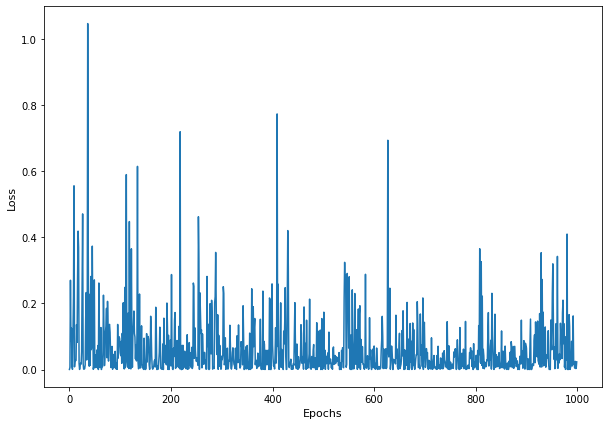

In [140]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
    game = Gridworld(size=4, mode='player')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
	#將3維陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。編註：加上雜訊的原因會在稍後說明
    state1 = torch.from_numpy(state_).float()
#將numpy陣列轉換成PyTorch張量，並存於PyTorch變數（state1）中	
    status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
    while(status == 1):
        qval = model(state1) #執行Q網路，取得所有動作的預測Q值
        qval_ = qval.data.numpy() #將qval轉換成numpy陣列
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)        
        action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
        game.makeMove(action) #執行之前ε—貪婪策略所選出的動作 
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
        reward = game.reward()
        with torch.no_grad(): #此函式的作用會在稍後說明
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
        if reward == -1:
            Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach() #此函式的作用會在稍後說明
        X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape [1, 4] 會變成 [4])
        loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
        if i%100 == 0:
          print(i, loss.item())
          clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        state1 = state2
        if abs(reward) == 10:      
	   	      status = 0 # 若 reward 不等於 –1，代表遊戲已經分出勝負，所以設status為0  
    losses.append(loss.item())
    if epsilon > 0.1:
        epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 程式 3.3(random mode)

Text(0, 0.5, 'Loss')

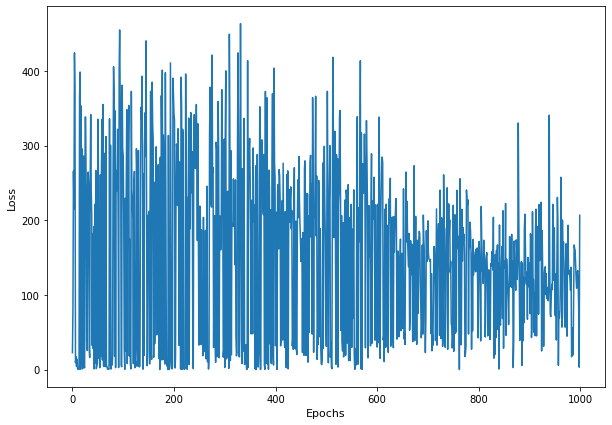

In [141]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
	#將3維陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。編註：加上雜訊的原因會在稍後說明
    state1 = torch.from_numpy(state_).float()
#將numpy陣列轉換成PyTorch張量，並存於PyTorch變數（state1）中	
    status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
    while(status == 1):
        qval = model(state1) #執行Q網路，取得所有動作的預測Q值
        qval_ = qval.data.numpy() #將qval轉換成numpy陣列
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)        
        action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
        game.makeMove(action) #執行之前ε—貪婪策略所選出的動作 
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
        reward = game.reward()
        with torch.no_grad(): #此函式的作用會在稍後說明
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
        if reward == -1:
            Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach() #此函式的作用會在稍後說明
        X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape [1, 4] 會變成 [4])
        loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
        if i%100 == 0:
          print(i, loss.item())
          clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        state1 = state2
        if abs(reward) == 10:      
	   	      status = 0 # 若 reward 不等於 –1，代表遊戲已經分出勝負，所以設status為0  
    losses.append(loss.item())
    if epsilon > 0.1:
        epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

### 測試模型 (random mode）

In [142]:
test_model(model, 'random')

Initial State:
[[' ' '+' 'W' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' '+' 'W' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[[' ' '+' 'W' '-']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[[' ' '+' 'W' '-']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: u
[[' ' '+' 'W' '-']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

## 程式 3.4

In [143]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

## 重建模型（程式3.2）

In [144]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

L1 = 64 #{4} 各層的寬度
L2 = 150
L3 = 100
L4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3  #超參數『α』
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #model.parameters()會傳回所有要優化的權重參數

gamma = 0.9
epsilon = 1.0

## 程式 3.5

Text(0, 0.5, 'Loss')

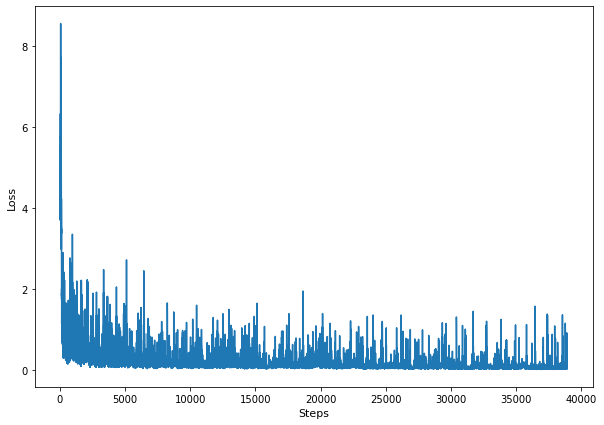

In [145]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定單一小批次（mini_batch）的大小
replay = deque(maxlen=mem_size) #產生一個deque串列來儲存經驗回放的資料
max_moves = 50 #設定每場遊戲最多可以走幾步
for i in range(epochs):
    
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0 #移動的步數
    while(status == 1): 
        mov += 1
        qval = model(state1) #輸出各動作的Q值
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)    
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        #reward = -5 if hit_wall else game.reward() #●2.若撞牆回饋-5
        done = True if reward != -1 else False #在reward不等於-1時設定done=True，代表遊戲已經結束了（分出勝負時，reward會等於10或-10）
        exp = (state1, action_, reward, state2, done) #產生一筆經驗，其中包含當前狀態、動作、新狀態、回饋值及done值
        replay.append(exp) #將該經驗加入名為replay的deque串列中
        state1 = state2 #產生的新狀態會變成下一次訓練時的輸入狀態          
        if len(replay) > batch_size: #當replay的長度大於小批次量（mini-batch size）時，啟動小批次訓練
            minibatch = random.sample(replay, batch_size) #隨機選擇replay中的資料來組成子集
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #{5}將經驗中的不同元素分別儲存到對應的小批次張量中
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]) 
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])            
            Q1 = model(state1_batch) #利用小批次資料中的目前狀態來計算Q值
            with torch.no_grad():
              Q2 = model(state2_batch) #利用小批次資料中的新狀態來計算Q值，但設定為不需要計算梯度         
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #計算我們希望DQN學習的目標Q值
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze() #gather()及unsqueeze()函式的用途可參見下面的小編補充框 
            loss = loss_fn(X, Y.detach())
            if i%100 == 0:
              print(i, loss.item())
              clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
        if abs(reward) == 10 or mov > max_moves:
            status = 0
            mov = 0 #若遊戲結束，則重設status和mov變數的值
    if epsilon > 0.1:
      epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
losses = np.array(losses)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

##程式 3.6

In [146]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

Games played: 1000, # of wins: 921
Win percentage: 92.10000000000001%


##程式 3.7

In [147]:
import copy

L1 = 64
L2 = 150
L3 = 100
L4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4)
)

model2 = copy.deepcopy(model) #完整複製原始Q網路模型，產生目標網路模型
model2.load_state_dict(model.state_dict()) #將原始Q網路中的參數複製給目標網路
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#sync_freq = 50
gamma = 0.9
epsilon = 1.0

## 程式 3.8

Text(0, 0.5, 'Loss')

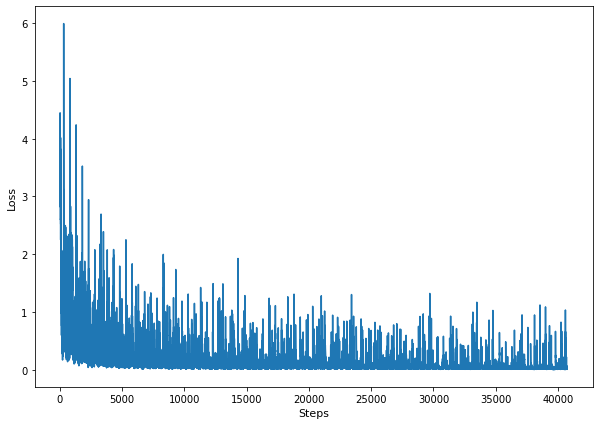

In [148]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
sync_freq = 500 #○1設定Q網路和目標網路的參數同步頻率
j=0 #○2當前訓練次數
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1 #○3將訓練次數加1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()

        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward != -1 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) 
        state1 = state2        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad(): #{2} ○4用目標網路模型計算Q值, 但不要優化模型的參數
                Q2 = model2(state2_batch)
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            if i%100 == 0:
              print(i, loss.item())
              clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()  
            losses.append(loss.item())                                 
            optimizer.step()            
            if j % sync_freq == 0: #{2}○5每過50次迴圈，就將Q網路當前的參數複製一份給目標網路
                model2.load_state_dict(model.state_dict())
        if abs(reward) == 10 or mov > max_moves:
            status = 0
            mov = 0
    if epsilon > 0.1:
        epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）              
losses = np.array(losses)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

##測試勝率

In [149]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

Games played: 1000, # of wins: 938
Win percentage: 93.8%


## 程式 3.5 改良版

In [150]:
# move_pos = [(-1,0),(1,0),(0,-1),(0,1)]   #●移動方向 u,d,l,r 的實際移動向量 
# model = torch.nn.Sequential(
#     torch.nn.Linear(L1, L2), #第一隱藏層
#     torch.nn.ReLU(),
#     torch.nn.Linear(L2, L3), #第二隱藏層
#     torch.nn.ReLU(),
#     torch.nn.Linear(L3,L4) #輸出層
# )
# loss_fn = torch.nn.MSELoss()
# learning_rate = 1e-3  #超參數『α』
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #model.parameters()會傳回所有要優化的權重參數

# gamma = 0.9
# epsilon = 1.0

# #————————————————

# from collections import deque
# epochs = 5000
# losses = []
# mem_size = 1000 #設定記憶串列的大小
# batch_size = 200 #設定單一小批次（mini_batch）的大小
# replay = deque(maxlen=mem_size) #產生一個deque串列來儲存經驗回放的資料
# max_moves = 50 #設定每場遊戲最多可以走幾步
# for i in range(epochs):
#     game = Gridworld(size=4, mode='random')
#     state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
#     state1 = torch.from_numpy(state1_).float()
#     status = 1
#     mov = 0 #移動的步數
#     while(status == 1): 
#         mov += 1
#         qval = model(state1) #輸出各動作的Q值
#         qval_ = qval.data.numpy()
#         if (random.random() < epsilon):
#             action_ = np.random.randint(0,4)
#         else:
#             action_ = np.argmax(qval_)    
#         hit_wall = game.validateMove('Player', move_pos[action_]) == 1 #●1.檢查並記錄是否撞牆
#         action = action_set[action_]
#         game.makeMove(action)
#         state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
#         state2 = torch.from_numpy(state2_).float()
#         reward = -5 if hit_wall else game.reward() #●2.若撞牆回饋-5
#         done = True if reward != -1 else False #在reward不等於-1時設定done=True，代表遊戲已經結束了（分出勝負時，reward會等於10或-10）
#         exp = (state1, action_, reward, state2, done) #產生一筆經驗，其中包含當前狀態、動作、新狀態、回饋值及done值
#         replay.append(exp) #將該經驗加入名為replay的deque串列中
#         state1 = state2 #產生的新狀態會變成下一次訓練時的輸入狀態          
#         if len(replay) > batch_size: #當replay的長度大於小批次量（mini-batch size）時，啟動小批次訓練
#             minibatch = random.sample(replay, batch_size) #隨機選擇replay中的資料來組成子集
#             state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #{5}將經驗中的不同元素分別儲存到對應的小批次張量中
#             action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
#             reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
#             state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]) 
#             done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])            
#             Q1 = model(state1_batch) #利用小批次資料中的目前狀態來計算Q值
#             with torch.no_grad():
#               Q2 = model(state2_batch) #利用小批次資料中的新狀態來計算Q值，但設定為不需要計算梯度         
#             Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #計算我們希望DQN學習的目標Q值
#             X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze() #gather()及unsqueeze()函式的用途可參見下面的小編補充框 
#             loss = loss_fn(X, Y.detach())
#             if i%100 == 0:
#               print(i, loss.item())
#               clear_output(wait=True)             
#             optimizer.zero_grad()
#             loss.backward()            
#             losses.append(loss.item())
#             optimizer.step()
#         if abs(reward) == 10 or mov > max_moves:
#             status = 0
#             mov = 0 #若遊戲結束，則重設status和mov變數的值
#     if epsilon > 0.1:
#       epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
# losses = np.array(losses)
# plt.figure(figsize=(10,7))
# plt.plot(losses)
# plt.xlabel("Steps",fontsize=11)
# plt.ylabel("Loss",fontsize=11)

# #——————————————

# max_games = 1000
# wins = 0
# for i in range(max_games):
#     win = test_model(model, mode='random', display=False)
#     if win:
#         wins += 1
# win_perc = float(wins) / float(max_games)
# print("Games played: {0}, # of wins: {1}".format(max_games,wins))
# print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

KeyboardInterrupt: ignored

In [ ]:
# max_games = 1000
# wins = 0
# for i in range(max_games):
#     win = test_model(model, mode='random', display=False, avoid_wall=False)
#     if win:
#         wins += 1
# win_perc = float(wins) / float(max_games)
# print("Games played: {0}, # of wins: {1}".format(max_games,wins))
# print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

## 程式 3.8 改良版

In [ ]:
# import copy

# L1 = 64
# L2 = 150
# L3 = 100
# L4 = 4

# model = torch.nn.Sequential(
#     torch.nn.Linear(L1, L2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(L2, L3),
#     torch.nn.ReLU(),
#     torch.nn.Linear(L3,L4)
# )

# model2 = copy.deepcopy(model) #完整複製原始Q網路模型，產生目標網路模型
# model2.load_state_dict(model.state_dict()) #將原始Q網路中的參數複製給目標網路
# loss_fn = torch.nn.MSELoss()
# learning_rate = 1e-3
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# #sync_freq = 50
# gamma = 0.9
# epsilon = 1.0


# from collections import deque
# epochs = 5000
# losses = []
# mem_size = 1500
# batch_size = 200
# replay = deque(maxlen=mem_size)
# max_moves = 50
# #h = 0
# sync_freq = 20 #○1設定Q網路和目標網路的參數同步頻率
# j=0 #○2當前訓練次數
# for i in range(epochs):
#     game = Gridworld(size=4, mode='random')
#     state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
#     state1 = torch.from_numpy(state1_).float()
#     status = 1
#     mov = 0
#     while(status == 1): 
#         j+=1 #○3將訓練次數加1
#         mov += 1
#         qval = model(state1) #輸出各動作的Q值
#         qval_ = qval.data.numpy()
#         if (random.random() < epsilon):
#             action_ = np.random.randint(0,4)
#         else:
#             action_ = np.argmax(qval_)    
#         hit_wall = game.validateMove('Player', move_pos[action_]) == 1 #●1.檢查並記錄是否撞牆
#         action = action_set[action_]
#         game.makeMove(action)
#         state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
#         state2 = torch.from_numpy(state2_).float()
#         # reward = game.reward()
#         reward = -5 if hit_wall else game.reward() #●2.若撞牆回饋-5
#         done = True if reward != -1 else False #在reward不等於-1時設定done=True，代表遊戲已經結束了（分出勝負時，reward會等於10或-10）
#         exp = (state1, action_, reward, state2, done) #產生一筆經驗，其中包含當前狀態、動作、新狀態、回饋值及done值
#         replay.append(exp) #將該經驗加入名為replay的deque串列中
#         state1 = state2 #產生的新狀態會變成下一次訓練時的輸入狀態     
        
#         if len(replay) > batch_size:
#             minibatch = random.sample(replay, batch_size)
#             state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
#             action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
#             reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
#             state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
#             done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
#             Q1 = model(state1_batch) 
#             with torch.no_grad(): #{2} ○4用目標網路模型計算Q值, 但不要優化模型的參數
#                 Q2 = model2(state2_batch)
#             Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
#             X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
#             loss = loss_fn(X, Y.detach())
#             if i%100 == 0:
#               print(i, loss.item())
#               clear_output(wait=True)
#             optimizer.zero_grad()
#             loss.backward()
#             losses.append(loss.item())
#             optimizer.step()
            
#             if j % sync_freq == 0: #{2}○5每過50次迴圈，就將Q網路當前的參數複製一份給目標網路
#                 model2.load_state_dict(model.state_dict())
#         if abs(reward) == 10 or mov > max_moves:
#             status = 0
#             mov = 0
#     if epsilon > 0.1:
#         epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
                
# losses = np.array(losses)
# plt.figure(figsize=(10,7))
# plt.plot(losses)
# plt.xlabel("Epochs",fontsize=22)
# plt.ylabel("Loss",fontsize=22)

# max_games = 1000
# wins = 0
# for i in range(max_games):
#     win = test_model(model, mode='random', display=False,avoid_wall=False)
#     if win:
#         wins += 1
# win_perc = float(wins) / float(max_games)
# print("Games played: {0}, # of wins: {1}".format(max_games,wins))
# print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率


In [ ]:
# max_games = 1000
# wins = 0
# for i in range(max_games):
#     win = test_model(model, mode='random', display=False, avoid_wall=False)
#     if win:
#         wins += 1
# win_perc = float(wins) / float(max_games)
# print("Games played: {0}, # of wins: {1}".format(max_games,wins))
# print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率